In [67]:
import numpy as np

from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.optimizers import rmsprop

import cv2

from matplotlib import pyplot as plt

In [22]:
def show_random_images(ds, labels, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(28, 28)
        plt.imshow(255 - image, cmap='gray')
        plt.title(LABELS[labels[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [17]:
def show_random_diff(ds_raw, ds_processed, labels, h=5, w=5):
    assert ds_raw.shape == ds_processed.shape
    
    idxs = np.random.randint(0, ds_raw.shape[0] - 1, size=w * h).tolist()
    plt.figure(figsize=(3 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = np.hstack([ds_raw[idx].reshape(28, 28),
                           ds_processed[idx].reshape(28, 28)])
        plt.imshow(image, cmap='gray')
        plt.title(LABELS[labels[idx]])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [80]:
def predict_random_images(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    labels = model.predict_classes(subset, verbose=0)
    
    plt.figure(figsize=(1.5 * w, 1.5 * h))    
    for i, label in enumerate(labels):
        plt.subplot(h, w, i + 1)
        image = subset[i].reshape(28, 28) * 255.
        image = image.astype(np.uint8)
        plt.imshow(image, cmap='gray')
        plt.title(LABELS[label])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [5]:
def show_random_predictions(ds, model, h=5, w=5):
    idxs = np.random.randint(0, ds.shape[0] - 1, size=w * h).tolist()
    subset = ds[idxs]
    plt.figure(figsize=(1.5 * w, 1.5 * h))
    for i, idx in enumerate(idxs):
        plt.subplot(h, w, i + 1)
        image = ds[idx].reshape(28, 28, 1)
        plt.imshow(image, cmap='gray')
        plt.title(labels[idx])
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()

In [6]:
def deskew_image(pixels):
    SZ = 28
    pixels = pixels.reshape(28, 28).astype(np.uint8)
    m = cv2.moments(pixels)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return pixels.copy().reshape(28*28)
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    pixels = cv2.warpAffine(pixels, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LANCZOS4)
    # Binarize image
    pixels = cv2.threshold(pixels.astype(np.uint8), 
                           0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    return pixels.reshape(28 * 28)

In [32]:
def plot_history(history, params=['loss', 'acc']):
    for param in params:
        plt.plot(history.history[param], label='train')
        if 'val_%s' % param in history.history.keys():
            plt.plot(history.history['val_%s' % param], label='test')
        plt.xlabel('epoch')
        plt.ylabel(param)
        plt.title(param.capitalize())
        plt.legend()
        plt.show()

In [33]:
LABELS = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
n_classes = len(LABELS)

In [34]:
n_channels = 1
image_height, image_width = 28, 28

In [54]:
(x_train_raw, y_train), (x_test_raw, y_test) = fashion_mnist.load_data()

In [55]:
print(x_train_raw.shape, y_train.shape) 
print(x_test_raw.shape, y_test.shape) 

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


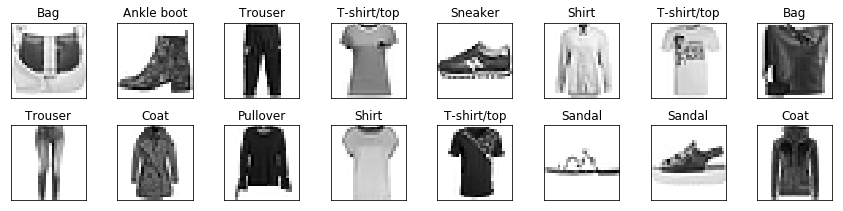

In [56]:
show_random_images(x_train_raw, y_train, 2, 8)
# show_random_images(x_test_raw, y_test)

In [57]:
x_train_raw = x_train_raw.reshape(-1, image_height, image_width, n_channels) / 255.
x_test_raw = x_test_raw.reshape(-1, image_height, image_width, n_channels) / 255.


y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

In [71]:
def build_model():
    model= Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
                     kernel_regularizer=l2(1e-4),
                     data_format='channels_last', input_shape=(image_height, image_width, n_channels)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                     kernel_regularizer=l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     kernel_regularizer=l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                     kernel_regularizer=l2(1e-4),
                     padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
        
    model.add(Flatten())

    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_classes, activation='softmax'))
    
    opt = rmsprop(lr=1e-3)

    model.compile(optimizer=opt, loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [72]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 32)        0         
__________

In [73]:
history = model.fit(x_train_raw, y_train, validation_data=(x_test_raw, y_test), epochs=5)

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 506s 8ms/step - loss: 0.5059 - acc: 0.8335 - val_loss: 0.3512 - val_acc: 0.8914
Epoch 2/5
60000/60000 [==============================] - 524s 9ms/step - loss: 0.3653 - acc: 0.8870 - val_loss: 0.3074 - val_acc: 0.8995
Epoch 3/5
60000/60000 [==============================] - 522s 9ms/step - loss: 0.3447 - acc: 0.8944 - val_loss: 0.3414 - val_acc: 0.8925
Epoch 4/5
60000/60000 [==============================] - 501s 8ms/step - loss: 0.3427 - acc: 0.9015 - val_loss: 0.2974 - val_acc: 0.9082
Epoch 5/5
60000/60000 [==============================] - 528s 9ms/step - loss: 0.3431 - acc: 0.9045 - val_loss: 0.2845 - val_acc: 0.9183


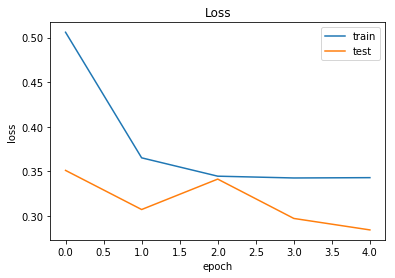

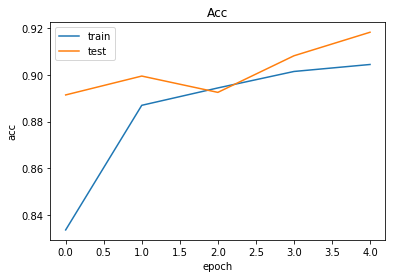

In [75]:
plot_history(history)

In [81]:
acc = 100 * model.evaluate(x_test_raw, y_test, verbose=0)[1]
print('Model 1 acc: %0.3f%%' % acc)

Model 1 acc: 91.830%


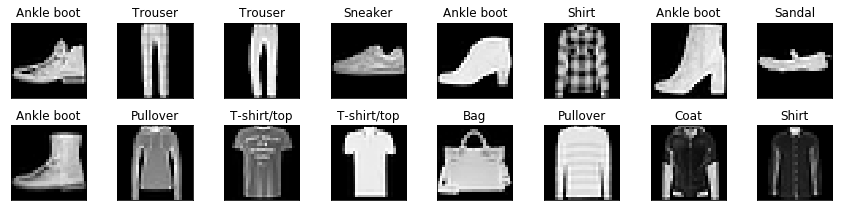

In [82]:
predict_random_images(x_test_raw, model, 2, 8)